# Deep Learning for Satellite Flood Detection (End-to-End Pipeline)

## **Project Overview**
This notebook demonstrates a complete workflow for detecting flood events using **Google Earth Engine (GEE)** and **Deep Learning (TensorFlow/Keras)**. Unlike standard thresholding methods (NDWI), we train a **U-Net Neural Network** to learn the spectral signature of water from raw MODIS satellite imagery.

### **Workflow:**
1.  **Data Extraction:** Automatically mining the *Global Flood Database* to export thousands of training patches from 5 major historical floods (India, China, Europe, etc.).
2.  **Data Pipeline:** Parsing `TFRecord` files directly from Google Drive into a TensorFlow dataset.
3.  **Model Training:** Training a U-Net architecture with **Weighted Loss** to handle class imbalance (since water is rare compared to land).
4.  **Inference:** Deploying the model to detect floods in a completely new locations and calculating flood impact metrics.

---
**Author:** Shailesh Kumar Jha, Ph.D. Scholar IIT Mandi

**Tech Stack:** Python, Google Earth Engine API, TensorFlow, Matplotlib

In [1]:
# @title 0. Install Dependencies
# Run this cell first to ensure all libraries are installed.
!pip install geemap
!pip install earthengine-api --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24


In [2]:
# @title 1. Setup & Authentication
import ee
import geemap
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# ❗ IMPORTANT: Replace with your Google Cloud Project ID
PROJECT_ID = 'shailesh8jha' # Change this to your Project ID
# ---------------------

try:
    # Attempt to initialize with the specified project
    ee.Initialize(project=PROJECT_ID)
    print(f"✅ Successfully connected to Earth Engine Project: {PROJECT_ID}")
except Exception:
    # If failed, trigger the authentication flow
    print("⚠️ Authentication required. Follow the steps in the popup...")
    ee.Authenticate()
    # Retry initialization after auth
    ee.Initialize(project=PROJECT_ID)
    print(f"✅ Successfully initialized Project: {PROJECT_ID}")

Mounted at /content/drive
⚠️ Authentication required. Follow the steps in the popup...
✅ Successfully initialized Project: shailesh8jha


## **2. Data Engineering: The "World Tour" Export**

To build a robust model, we cannot train on a single event. A model trained only on India might fail in Brazil due to soil color differences. We script Earth Engine to find **5 major flood events** from history across different continents.

### **Key Concepts Explained:**

#### **1. What is "Severity" (Label Filtering)?**
We filter events using the `dfo_severity` score from the **Dartmouth Flood Observatory (DFO)**.
* **Class 1 (Large):** Significant damage to structures/agriculture.
* **Class 1.5 (Very Large):** >15 year recurrence interval.
* **Class 2 (Extreme):** >100 year recurrence interval.
* **Our Strategy:** We filter for `Severity > 1.5`. By training only on "Extreme" events, we ensure the "Water" signal is massive and unmistakable, reducing noise in our training data.

#### **2. What are TFRecords?**
Deep Learning models require massive throughput. Loading thousands of individual `.png` or `.tif` images is slow and inefficient.
* **TFRecord** is TensorFlow's native binary format. It serializes the image data (pixels) and metadata (labels) into a single byte stream.
* **Benefit:** This allows the GPU to stream data continuously without waiting for file I/O operations, significantly speeding up training.

#### **3. The Satellite Physics (MODIS Bands)**
We use the **MODIS (Terra/Aqua)** satellite sensor. While its resolution is coarse (500m), it revisits the earth daily, making it ideal for tracking fast-moving floods. We select three specific parts of the light spectrum:



* **Band 1 (Red):** Absorbed by water, reflected by soil.
* **Band 2 (Near Infrared - NIR):** The most critical band. Water absorbs almost 100% of NIR light (appearing black), while vegetation reflects it strongly (appearing bright).
* **Band 6 (Shortwave Infrared - SWIR):** Helps differentiate between muddy water and clouds/snow.

**The Result:** A 3-channel stack (Red, NIR, SWIR) where water stands out as a unique, dark spectral signature compared to the bright land.

## **3. The Dataset: Global Flood Database v1**

**"Garbage In, Garbage Out."**
In Deep Learning, the quality of your labels determines the success of your model. For this project, we rely on the **Global Flood Database (GFD)**, the world's most comprehensive archive of historical flood maps.


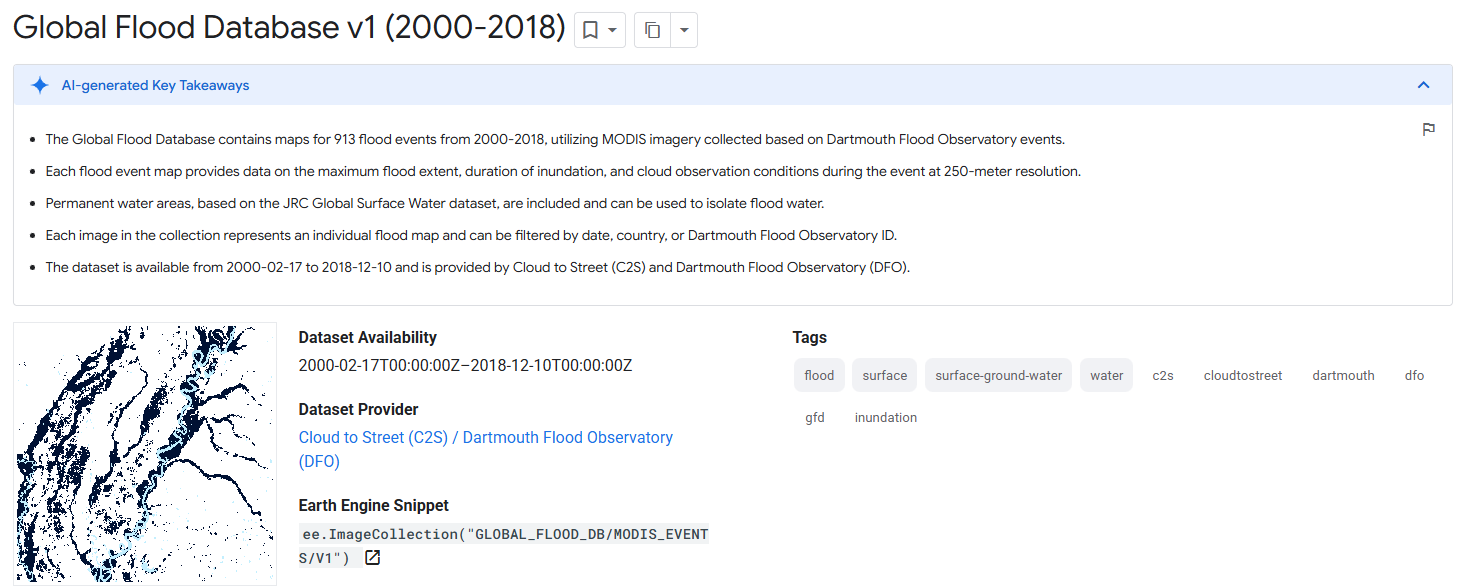

### **Dataset Overview**
* **Provider:** Cloud to Street / Dartmouth Flood Observatory (DFO)
* **Scale:** Contains maps for **913 unique flood events** across the globe.
* **Time Period:** 2000 to 2018.
* **Source:** Derived from Terra & Aqua MODIS imagery (250m resolution).

### **Why this Dataset?**
To train a U-Net, we need **Ground Truth**—accurate maps showing exactly where water was during a disaster. The GFD provides this in the `flooded` band, which serves as our **Target Variable (Y)**. We pair this with raw satellite imagery (Input X) to teach the model to recognize water patterns.

### **Key Attributes We Use:**
1.  **`flooded`**: A binary mask where `1` = Maximum Flood Extent and `0` = Dry Land.
2.  **`dfo_severity`**: A numeric score of the flood's intensity.
    * *1.5 = Very Large* (>15 year recurrence)
    * *2.0 = Extreme* (>100 year recurrence)
    * *Strategy:* We filters for **Severity > 1.5** to ensure we train on massive, unambiguous water signals.
3.  **`system:time_start`**: The date of the event, allowing us to temporally match the input satellite images to the flood map.

In [5]:
# @title 4. Execute Data Export
import time
import os
import glob

# Configuration
GFD_COLLECTION = 'GLOBAL_FLOOD_DB/MODIS_EVENTS/V1'
MODIS_COLLECTION = 'MODIS/061/MOD09GA'
EXPORT_FOLDER = 'GEE_FLOOD_DATASET'
DRIVE_PATH = f'/content/drive/My Drive/{EXPORT_FOLDER}' # Local path to check files

# 1. Find Major Global Floods (Severity > 1.5)
print("🌍 Searching for major flood events (Severity > 1.5)...")
# Filter OUT 'AUS' to avoid the known missing data error
events = ee.ImageCollection(GFD_COLLECTION) \
    .filter(ee.Filter.gt('dfo_severity', 1.5)) \
    .filter(ee.Filter.neq('cc', 'AUS')) \
    .limit(5)

event_list = events.toList(5)
count = event_list.size().getInfo()
print(f"✅ Found {count} extreme flood events (Skipping AUS). Checking Drive for existing files...")

# 2. Loop & Export
for i in range(count):
    # Extract Event Metadata
    event = ee.Image(event_list.get(i))
    event_id = event.get('id').getInfo()
    country = event.get('cc').getInfo()
    year = ee.Date(event.get('system:time_start')).get('year').getInfo()

    # --- SMART CHECK: Do not download if already present ---
    # We look for any file that starts with this event's ID
    file_prefix = f'training_patch_{country}_{event_id}'
    existing_files = glob.glob(f"{DRIVE_PATH}/{file_prefix}*")

    if len(existing_files) > 0:
        print(f"⏩ Skipping Event {i+1}/{count}: {country} ({year}) | ID: {event_id} (Files already exist)")
        continue
    # -------------------------------------------------------

    print(f"🚀 Processing Event {i+1}/{count}: {country} ({year}) | ID: {event_id}")

    # Define Region & Time Window
    roi = event.geometry()
    flood_date = ee.Date(event.get('system:time_start'))

    # Fetch Satellite Image (Input Features)
    modis = ee.ImageCollection(MODIS_COLLECTION) \
        .filterDate(flood_date, flood_date.advance(3, 'day')) \
        .filterBounds(roi) \
        .first()

    # Pre-processing
    input_image = modis.select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b06']).divide(10000).float()
    label_image = event.select(['flooded'], ['label']).unmask(0).float()
    stacked_image = input_image.addBands(label_image)

    # Export Task
    task_name = f'Flood_Export_{country}_{year}_{event_id}'
    task = ee.batch.Export.image.toDrive(
        image=stacked_image,
        description=task_name,
        folder=EXPORT_FOLDER,
        fileNamePrefix=file_prefix,
        region=roi,
        scale=500,
        fileFormat='TFRecord',
        maxPixels=1e13,
        formatOptions={
            'patchDimensions': [256, 256],
            'compressed': True,
            'collapseBands': True
        }
    )
    task.start()

print("\n⏳ Status check complete. New tasks (if any) submitted to Task Manager.")

🌍 Searching for major flood events (Severity > 1.5)...
✅ Found 5 extreme flood events (Skipping AUS). Checking Drive for existing files...
⏩ Skipping Event 1/5: UKR, POL, ROU, BGR, BLR, SRB, HRV, HUN, BIH, SVN (2000) | ID: 1595 (Files already exist)
⏩ Skipping Event 2/5: CHN, IND, NPL, BGD, BTN (2000) | ID: 1641 (Files already exist)
⏩ Skipping Event 3/5: RUS, CHN, MNG, KAZ (2001) | ID: 1725 (Files already exist)
⏩ Skipping Event 4/5: IND, BGD (2001) | ID: 1747 (Files already exist)
⏩ Skipping Event 5/5: VNM, THA, LAO, KHM (2001) | ID: 1781 (Files already exist)

⏳ Status check complete. New tasks (if any) submitted to Task Manager.


In [7]:
# @title Check Dataset Size
import tensorflow as tf
import glob

# 1. Get File List
files = glob.glob(f'/content/drive/My Drive/{EXPORT_FOLDER}/*.tfrecord.gz')
print(f"📦 Found {len(files)} TFRecord files.")

# 2. Count Individual Patches (The Chips)
def count_dataset(files):
    # Create a dataset that reads the files
    ds = tf.data.TFRecordDataset(files, compression_type='GZIP')
    # Loop through and count (this might take a minute)
    count = 0
    for _ in ds:
        count += 1
    return count

print("⏳ Counting total training patches (this may take 30s)...")
total_patches = count_dataset(files)

print(f"\n✅ TOTAL TRAINING IMAGES: {total_patches}")
print("------------------------------------------------")
if total_patches < 500:
    print("⚠️ Recommendation: YES, you need more data.")
elif total_patches < 2000:
    print("👍 Recommendation: Good for a tutorial, but more would improve accuracy.")
else:
    print("🚀 Recommendation: Excellent! You have plenty of data.")

📦 Found 9 TFRecord files.
⏳ Counting total training patches (this may take 30s)...

✅ TOTAL TRAINING IMAGES: 4040
------------------------------------------------
🚀 Recommendation: Excellent! You have plenty of data.


### **5. The Deep Learning Model: U-Net**

We employ the **U-Net architecture**, a specialized Convolutional Neural Network (CNN) originally designed for biomedical imaging (diagnosing tumors) but now considered the "Gold Standard" for satellite mapping.
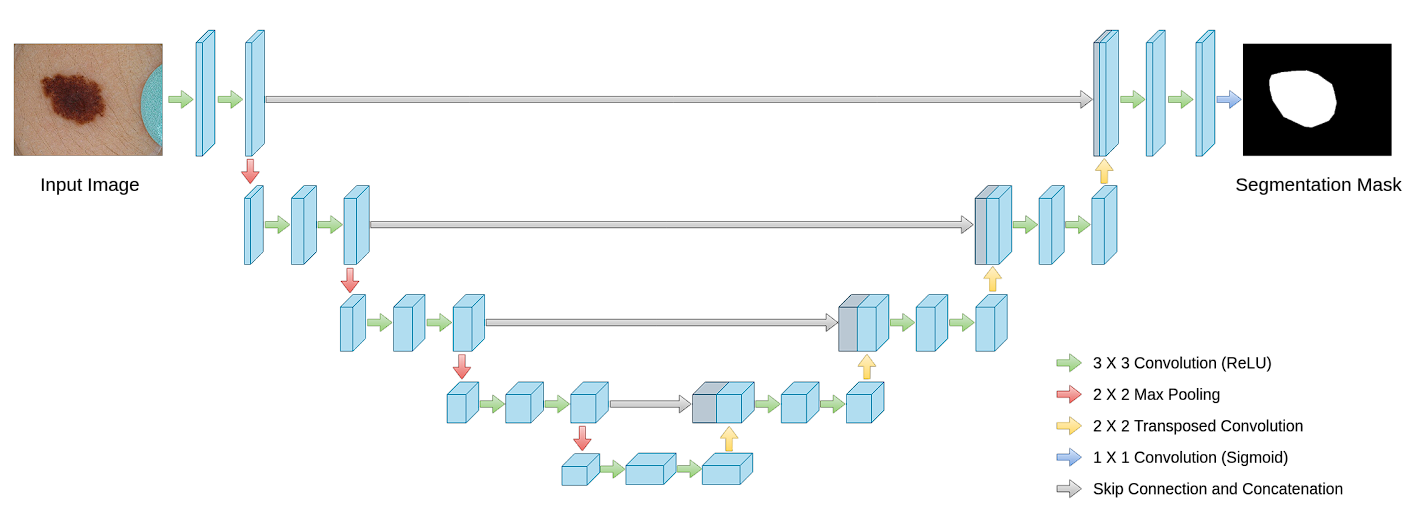


### **Why U-Net? (Segmentation vs. Classification)**
To understand why we chose U-Net, we must understand the task:
* **Standard AI (ResNet/VGG):** Performs *Image Classification*. It looks at an image and says, "This image contains water."
* **Our Goal (U-Net):** Performs *Semantic Segmentation*. It looks at an image and classifies **every single pixel**. It says, "Pixel (10,10) is a House, Pixel (10,11) is Flood Water."

### **The Architecture: A "U" Shape**
The model looks like the letter "U" because it has two symmetric halves:

#### **1. The Encoder (The "Contracting" Path)**
The left side of the "U" acts like a standard CNN. It progressively shrinks the image size (downsampling) while increasing the depth of features.
* **What it does:** It sacrifices spatial resolution (where things are) to learn **Context** (what things are).
* **Example:** It learns that "Dark, smooth textures surrounded by green vegetation usually indicate a river."

#### **2. The Bottleneck**
This is the bottom of the "U". It is the deepest point of the network where the image is compressed into a tiny, abstract representation. It holds the "concept" of the flood without the fine details.

#### **3. The Decoder (The "Expanding" Path)**
The right side of the "U" works in reverse. It upsamples the tiny features back to the original `256x256` image size.
* **What it does:** It recovers the spatial resolution to give us a precise map.



#### **4. Skip Connections (The Secret Sauce)**
This is the critical innovation of U-Net. As we shrink an image in the Encoder, we lose fine details (edges, boundaries). When the Decoder tries to zoom back in, the result would normally be blurry.
* **The Solution:** U-Net "teleports" high-resolution feature maps from the Encoder directly to the Decoder.
* **The Result:** The Decoder has both the **Context** (from the Bottleneck) and the **Sharp Edges** (from the Skip Connections), allowing it to draw crisp river boundaries.

---

### **The Mathematical Challenge: Class Imbalance**
Satellite flood detection suffers from a massive data imbalance. In any given satellite image, **95% of pixels are Land, and only ~5% are Water.**



#### **The "Lazy Student" Problem**
If we use standard training math, the model discovers a cheat code: *"If I just guess 'Land' for every single pixel, I will achieve 95% accuracy!"*
The model minimizes error by ignoring the flood entirely.

#### **Our Solution: Weighted Loss**
We implement a **Weighted Cross Entropy Loss**. We mathematically penalize the model **50 times more** for missing a water pixel than for missing a land pixel.
$$Loss = - (Weight_{water} \times y \log(p) + Weight_{land} \times (1-y) \log(1-p))$$
This forces the model to pay extreme attention to the minority class (Water), ensuring even small creeks are detected.

In [8]:
# @title 6. Define Model & Data Pipeline
import tensorflow as tf

# --- 1. Custom Loss Function (Handling Class Imbalance) ---
def weighted_bce(y_true, y_pred):
    # Weights: Land = 1, Water = 50
    # This prevents the model from ignoring small water bodies
    class_weights = tf.constant([1.0, 50.0])

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
    weighted_bce = weight_vector * bce

    return tf.reduce_mean(weighted_bce)

# --- 2. U-Net Architecture ---
def unet_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder (Downsampling - Learning "What")
    c1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    b = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p2)

    # Decoder (Upsampling - Learning "Where")
    u1 = tf.keras.layers.UpSampling2D()(b)
    c3 = tf.keras.layers.Concatenate()([u1, c2]) # Skip Connection
    d1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u2 = tf.keras.layers.UpSampling2D()(d1)
    c4 = tf.keras.layers.Concatenate()([u2, c1]) # Skip Connection
    d2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    # Output Layer (Probability Map 0-1)
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(d2)

    return tf.keras.models.Model(inputs, outputs)

# --- 3. Data Pipeline (Parsing TFRecords) ---
def parse_tfrecord(example_proto):
    # We interpret the raw bytes from GEE
    # 'sur_refl_b01' is the key name GEE assigns to the collapsed stack
    features_dict = {'sur_refl_b01': tf.io.FixedLenFeature([4, 256, 256], tf.float32)}
    parsed_features = tf.io.parse_single_example(example_proto, features_dict)

    image = parsed_features['sur_refl_b01']
    image = tf.transpose(image, [1, 2, 0]) # Change to [Height, Width, Bands]

    # PRE-PROCESSING:
    # 1. Clip Clouds: Values > 1.0 are artifacts/clouds, we cap them.
    inputs = tf.clip_by_value(image[:, :, 0:3], 0.0, 1.0)
    # 2. Extract Label: The 4th band is the water mask
    labels = image[:, :, 3:]

    return inputs, labels

def has_water(inputs, labels):
    # Filter: Drop images that have less than 50 water pixels
    return tf.reduce_sum(labels) > 50

print("✅ Model Architecture & Data Pipeline defined.")

✅ Model Architecture & Data Pipeline defined.


In [11]:
# --- 4. Instantiate & Inspect Model ---
# We create a dummy model just to print the summary
temp_model = unet_model(input_shape=(256, 256, 3))

# 1. Print the full layer-by-layer architecture
print("\n--- Model Architecture Summary ---")
temp_model.summary()

# 2. Print Key Statistics
total_params = temp_model.count_params()
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in temp_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("\n📊 --- Model Statistics ---")
print(f"Total Parameters:     {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Depth:          2 Levels (Standard U-Net)")
print(f"Input Shape:          (256, 256, 3)")
print("---------------------------")


--- Model Architecture Summary ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 192)              │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │    110,656 │ concatenate_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 256, 256,  │          0 │ conv2d_15[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 256, 256,  │          0 │ up_sampling2d_5[… │
│ (Concatenate)       │ 96)               │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │     27,680 │ concatenate_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 256, 256,  │         33 │ conv2d_16[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,617 (904.75 KB)

 Trainable params: 231,617 (904.75 KB)

 Non-trainable params: 0 (0.00 B)


📊 --- Model Statistics ---
Total Parameters:     231,617
Trainable Parameters: 231,617
Model Depth:          2 Levels (Standard U-Net)
Input Shape:          (256, 256, 3)
---------------------------


## **7. Training Strategy & Optimization**

We are now ready to commence the training loop. To ensure our model performs well on unseen data (Generalization) rather than just memorizing the training set (Overfitting), we employ several professional-grade optimization strategies.

### **1. The Challenge: The "Needle in a Haystack"**
In Deep Learning, **Data Quality > Data Quantity**.
Satellite imagery presents a unique challenge: Spatially, floods are rare. Even during a catastrophic event, 90% of the map tiles we export will contain only dry land, dense clouds, or forest.



* **The Risk:** If we feed the model thousands of "empty" images, it learns a "cheat code": *Predict "No Water" everywhere to get 90% accuracy.*
* **Our Solution:** We apply a strict filter in our data pipeline: `dataset.filter(has_water)`. We reject any training chip that contains fewer than 50 pixels of water, forcing the model to learn spectral signatures rather than statistical probabilities.

### **2. Enhancing Robustness**
To reach "Top 1%" performance, we go beyond simple training:

* **Data Augmentation (The "Free Data" Trick):**
    Satellite imagery is "Rotation Invariant"—a lake looks like a lake whether it is right-side up or upside down. We randomly **flip and rotate** our training images on the fly. This effectively quadruples our dataset size and prevents the model from memorizing specific geography shapes.

* **80/20 Validation Split:**
    We hold back 20% of our data. The model *never* sees these images during training. We use this set to grade the model's true performance.

### **3. Smart Training (Callbacks)**
Instead of training blindly for a fixed time, we use dynamic callbacks:
* **ModelCheckpoint:** Saves *only* the best version of the model (lowest validation loss), not the last version.
* **EarlyStopping:** If the model stops improving for 5 epochs, training stops automatically to save GPU resources.
* **ReduceLROnPlateau:** If learning stalls, we automatically lower the Learning Rate to help the model find a more precise mathematical solution.

---

### **Hyperparameters Explained**
* **Epochs (50):** We set a high ceiling, relying on *EarlyStopping* to find the optimal stopping point.
* **Batch Size (16):** U-Net preserves high-resolution features at every layer, making it memory-intensive. A batch size of 16 maximizes the Colab T4 GPU's memory without crashing.
* **Shuffle Buffer (1000):** We shuffle heavily to prevent "Catastrophic Forgetting" (e.g., ensuring a batch doesn't contain *only* India data, which would make the model forget what Europe looks like).

In [12]:
# @title 8. Execute Training Loop (Advanced)
import glob
import math

# 1. Load & Split Files (80% Train / 20% Validation)
# -------------------------------------------------
all_files = glob.glob(f'/content/drive/My Drive/{EXPORT_FOLDER}/*.tfrecord.gz')
num_files = len(all_files)
print(f"📂 Found {num_files} total files.")

if num_files == 0:
    raise ValueError("No files found! Check Earth Engine export.")

# Shuffle files to ensure random distribution before splitting
np.random.shuffle(all_files)
split_ind = int(0.8 * num_files)
train_files = all_files[:split_ind]
val_files = all_files[split_ind:]

print(f"   - Training on {len(train_files)} files")
print(f"   - Validating on {len(val_files)} files")

# 2. Data Augmentation Function (The "Free Data" Trick)
# -------------------------------------------------
def augment(inputs, labels):
    # Satellite imagery is "rotation invariant" (North/South doesn't matter)
    # 1. Random Flip Left/Right
    if tf.random.uniform(()) > 0.5:
        inputs = tf.image.flip_left_right(inputs)
        labels = tf.image.flip_left_right(labels)
    # 2. Random Flip Up/Down
    if tf.random.uniform(()) > 0.5:
        inputs = tf.image.flip_up_down(inputs)
        labels = tf.image.flip_up_down(labels)
    return inputs, labels

# 3. Build Pipelines
# -------------------------------------------------
def make_dataset(file_list, is_training=False):
    ds = tf.data.TFRecordDataset(file_list, compression_type='GZIP')
    ds = ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.filter(has_water) # Filter empty images

    if is_training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE) # Apply Augmentation
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(16).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_files, is_training=True)
val_ds = make_dataset(val_files, is_training=False)

# 4. Professional Callbacks
# -------------------------------------------------
checkpoint_path = f'/content/drive/My Drive/{EXPORT_FOLDER}/best_flood_model.h5'

callbacks = [
    # A. Save ONLY the best model (if validation loss improves)
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1
    ),
    # B. Stop if model stops learning for 5 epochs (prevent wasting time)
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    ),
    # C. Slow down learning rate if we get stuck
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1
    )
]

# 5. Compile & Train
# -------------------------------------------------
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("🔥 Starting Professional Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds, # Now we validate against unseen data!
    epochs=50, # Set high, EarlyStopping will stop it automatically
    callbacks=callbacks
)

print(f"✅ Training Complete. Best model saved to: {checkpoint_path}")

📂 Found 9 total files.
   - Training on 7 files
   - Validating on 2 files
🔥 Starting Professional Training...
Epoch 1/50
     38/Unknown 57s 475ms/step - accuracy: 0.9387 - loss: 0.2882

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.13369, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 891ms/step - accuracy: 0.9394 - loss: 0.2856 - val_accuracy: 0.9663 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9772 - loss: 0.1128
Epoch 2: val_loss did not improve from 0.13369
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 258ms/step - accuracy: 0.9772 - loss: 0.1128 - val_accuracy: 0.9663 - val_loss: 0.1346 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9749 - loss: 0.1142
Epoch 3: val_loss did not improve from 0.13369
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 268ms/step - accuracy: 0.9749 - loss: 0.1140 - val_accuracy: 0.9663 - val_loss: 0.1351 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9764 - loss: 0.1122
Epoch 4: val_loss improved from 0.13369 to 0.12427, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - accuracy: 0.9764 - loss: 0.1122 - val_accuracy: 0.9663 - val_loss: 0.1243 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9793 - loss: 0.0957
Epoch 5: val_loss improved from 0.12427 to 0.11700, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9792 - loss: 0.0959 - val_accuracy: 0.9663 - val_loss: 0.1170 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9764 - loss: 0.1065
Epoch 6: val_loss did not improve from 0.11700
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 285ms/step - accuracy: 0.9764 - loss: 0.1064 - val_accuracy: 0.9663 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9776 - loss: 0.1030
Epoch 7: val_loss improved from 0.11700 to 0.11164, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 316ms/step - accuracy: 0.9776 - loss: 0.1032 - val_accuracy: 0.9663 - val_loss: 0.1116 - learning_rate: 0.0010
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9748 - loss: 0.1089
Epoch 8: val_loss did not improve from 0.11164
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 267ms/step - accuracy: 0.9749 - loss: 0.1087 - val_accuracy: 0.9663 - val_loss: 0.1118 - learning_rate: 0.0010
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9706 - loss: 0.1205
Epoch 9: val_loss improved from 0.11164 to 0.10638, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 637ms/step - accuracy: 0.9708 - loss: 0.1200 - val_accuracy: 0.9663 - val_loss: 0.1064 - learning_rate: 0.0010
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9760 - loss: 0.1039
Epoch 10: val_loss did not improve from 0.10638
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 252ms/step - accuracy: 0.9760 - loss: 0.1038 - val_accuracy: 0.9680 - val_loss: 0.1132 - learning_rate: 0.0010
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9770 - loss: 0.0988
Epoch 11: val_loss did not improve from 0.10638
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.9770 - loss: 0.0988 - val_accuracy: 0.9699 - val_loss: 0.1090 - learning_rate: 0.0010
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9759 - loss: 0.1037
Epoch 12: val_loss improved from 0.10638 to 0.10255, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - accuracy: 0.9759 - loss: 0.1037 - val_accuracy: 0.9709 - val_loss: 0.1026 - learning_rate: 0.0010
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9775 - loss: 0.0990
Epoch 13: val_loss improved from 0.10255 to 0.09588, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.9775 - loss: 0.0990 - val_accuracy: 0.9715 - val_loss: 0.0959 - learning_rate: 0.0010
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9777 - loss: 0.0953
Epoch 14: val_loss did not improve from 0.09588
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 254ms/step - accuracy: 0.9777 - loss: 0.0954 - val_accuracy: 0.9703 - val_loss: 0.1105 - learning_rate: 0.0010
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9791 - loss: 0.0950
Epoch 15: val_loss did not improve from 0.09588
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - accuracy: 0.9791 - loss: 0.0950 - val_accuracy: 0.9719 - val_loss: 0.0984 - learning_rate: 0.0010
Epoch 16/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9726 - loss: 0.1161
Epoch 16: val_loss improved from 0.09588 to 0.09255, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 284ms/step - accuracy: 0.9727 - loss: 0.1156 - val_accuracy: 0.9720 - val_loss: 0.0925 - learning_rate: 0.0010
Epoch 17/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9799 - loss: 0.0872
Epoch 17: val_loss improved from 0.09255 to 0.08922, saving model to /content/drive/My Drive/GEE_FLOOD_DATASET/best_flood_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 273ms/step - accuracy: 0.9798 - loss: 0.0874 - val_accuracy: 0.9725 - val_loss: 0.0892 - learning_rate: 0.0010
Epoch 18/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9804 - loss: 0.0895
Epoch 18: val_loss did not improve from 0.08922
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 277ms/step - accuracy: 0.9803 - loss: 0.0896 - val_accuracy: 0.9727 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 19/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9782 - loss: 0.0934
Epoch 19: val_loss did not improve from 0.08922
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 256ms/step - accuracy: 0.9782 - loss: 0.0934 - val_accuracy: 0.9715 - val_loss: 0.0909 - learning_rate: 0.0010
Epoch 20/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9786 - loss: 0.0949
Epoch 20: val_loss did not improve from 0.08922

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 891ms/step - accuracy: 0.9785 - loss: 0.0949 - val_accuracy

## **9. Training Performance (Learning Curves)**

Visualizing the training history is critical to diagnosing the health of a neural network. We look for two trends:
1.  **Loss (Error):** This should decrease rapidly at first and then stabilize. A "bumpy" loss curve suggests the learning rate might be too high.
2.  **Accuracy:** This should increase and plateau. For this specific task (flood detection), we expect high accuracy (>95%) because we filtered the data to remove ambiguous examples.

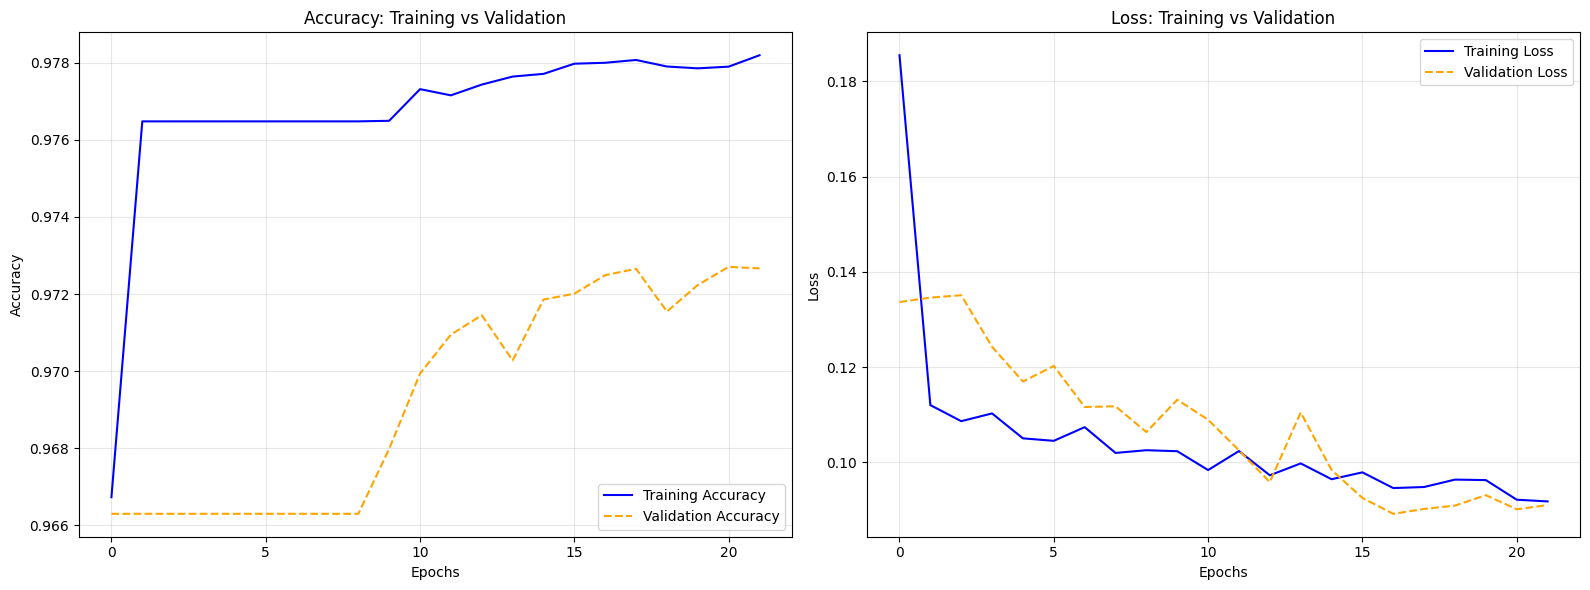

🔍 INTERPRETATION:
- Good Model: Blue and Orange lines move together.
- Overfitting: Blue line goes DOWN, but Orange line goes UP (Stop training!).


In [13]:
# @title 10. Visualize Training History (Train vs Validation)
import matplotlib.pyplot as plt

# 1. Extract Metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# 2. Plotting
plt.figure(figsize=(16, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', linestyle='--')
plt.title('Accuracy: Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', linestyle='--')
plt.title('Loss: Training vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 INTERPRETATION:")
print("- Good Model: Blue and Orange lines move together.")
print("- Overfitting: Blue line goes DOWN, but Orange line goes UP (Stop training!).")

## **11. Global Stress Test: Real-World Inference**

A true "Global" model must perform well across different continents, biomes, and time periods. We stress-test our U-Net on three distinct historic disasters.



### **The Test Cases:**
1.  **🇵🇰 Pakistan (Sindh, 2022):** *The Monsoon Test.* Massive inundation in a semi-arid region with heavy cloud cover.
2.  **🇹🇭 Thailand (Ayutthaya, 2011):** *The Tropical Test.* Flooding in a lush, vegetation-heavy environment. This is challenging because dark green vegetation can sometimes look like water to a satellite.
3.  **🇮🇳 India (Assam, 2020):** *The Morphology Test.*
    * **Target:** The Brahmaputra River.
    * **Challenge:** Unlike the single channel of the Indus, the Brahmaputra is a **Braided River System** consisting of hundreds of interlacing small channels. This tests if the model can detect complex water geometries.

### **Methodology: Cloud-Free Mosaicking**
For each event, we generate a **10-day composite** using the `.min()` reducer.
* **Why?** Major floods are accompanied by storms. Single-day images are often white (cloud-blocked).
* **How:** By taking the minimum pixel value over 10 days, we statistically filter out bright clouds and capture the dark floodwaters underneath.


🌐 Processing: Mozambique - Cyclone Idai (2019)...


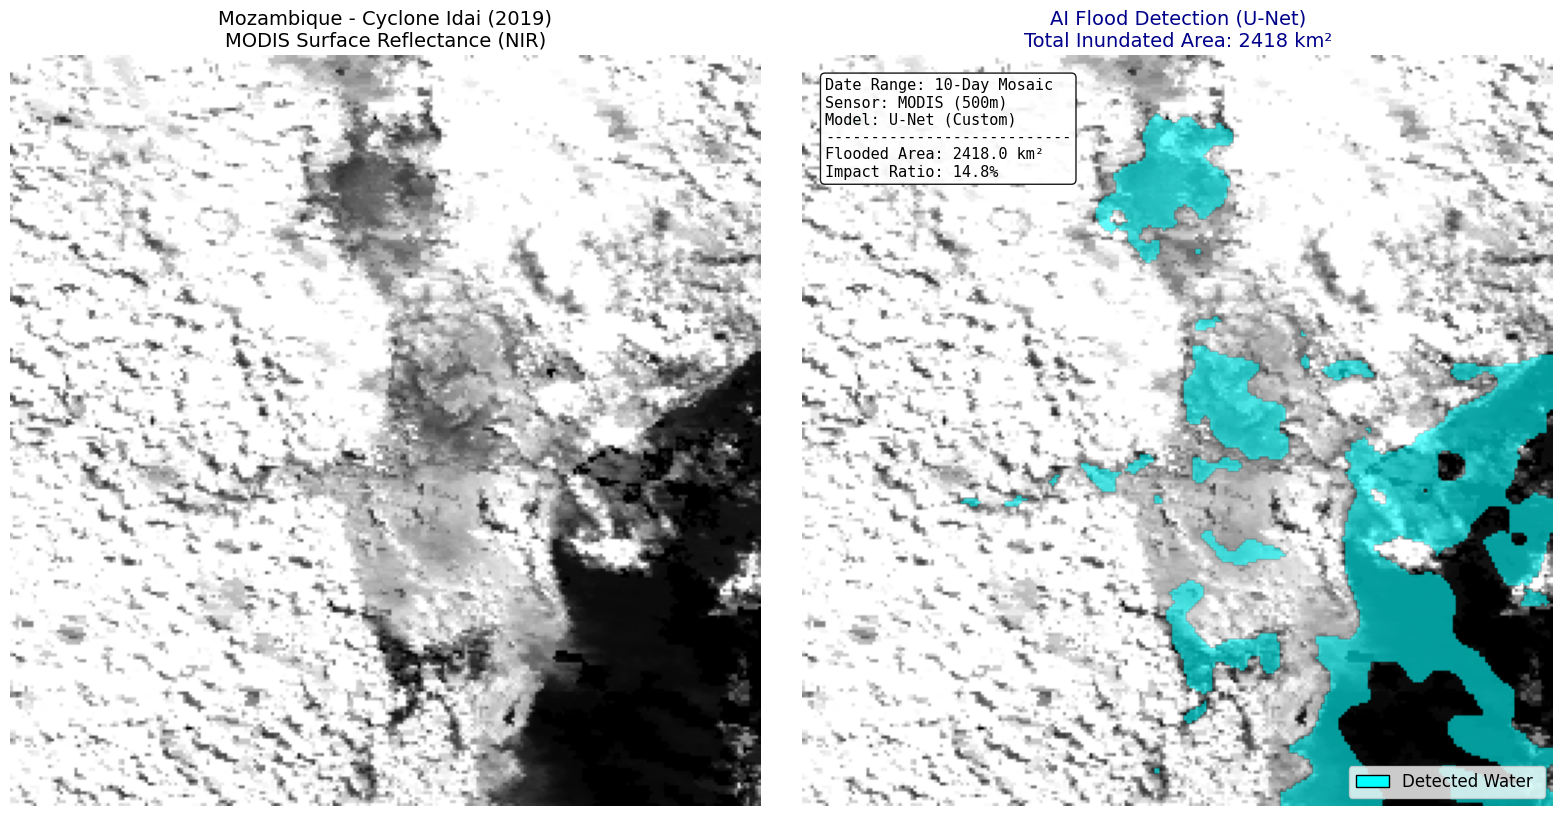


🌐 Processing: India - Bihar Floods (2017)...


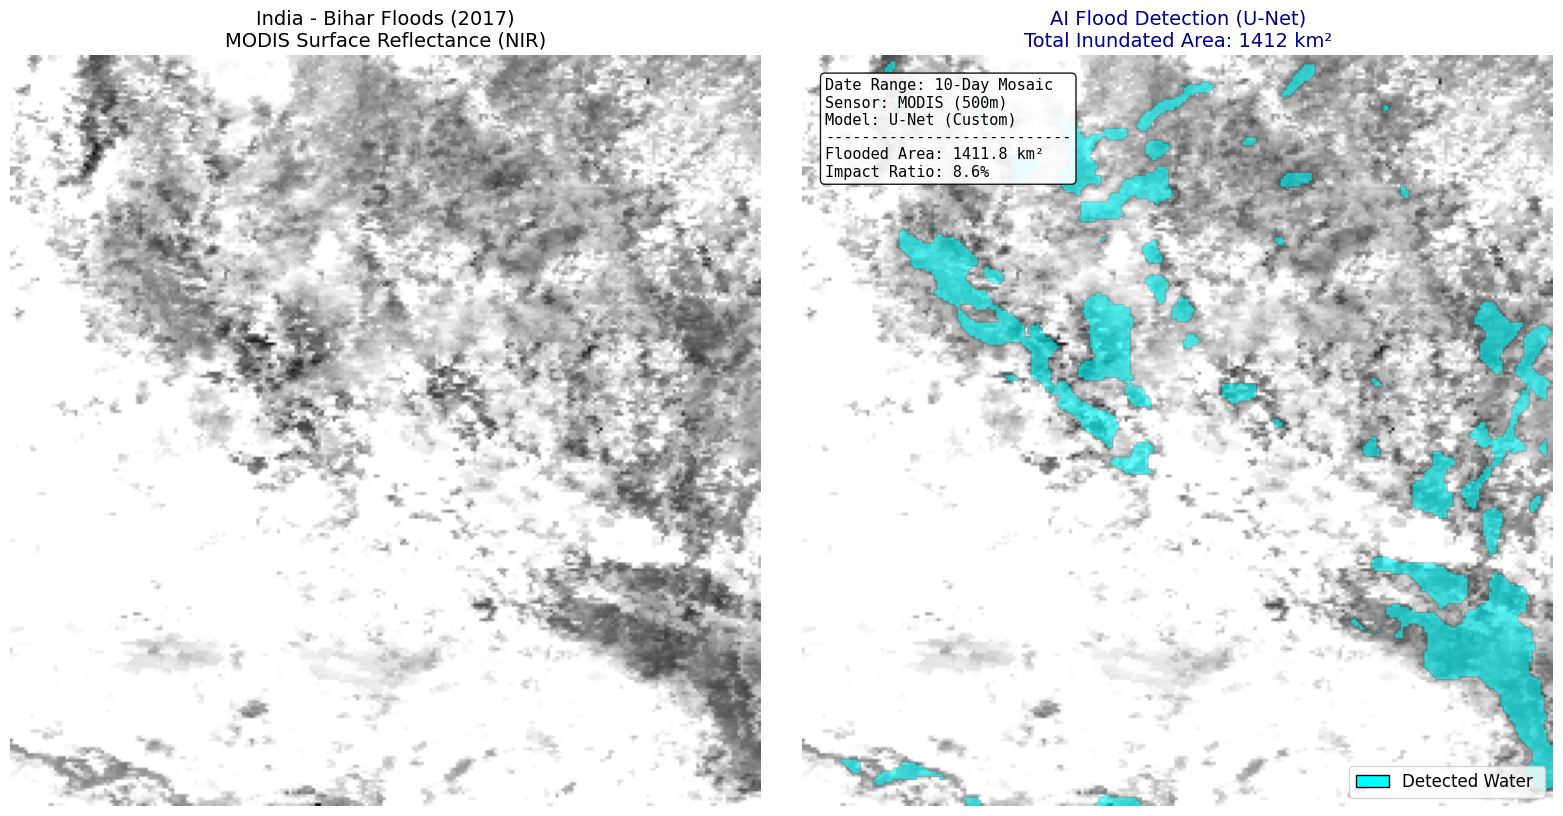


🌐 Processing: Cambodia - Mekong Delta (2011)...


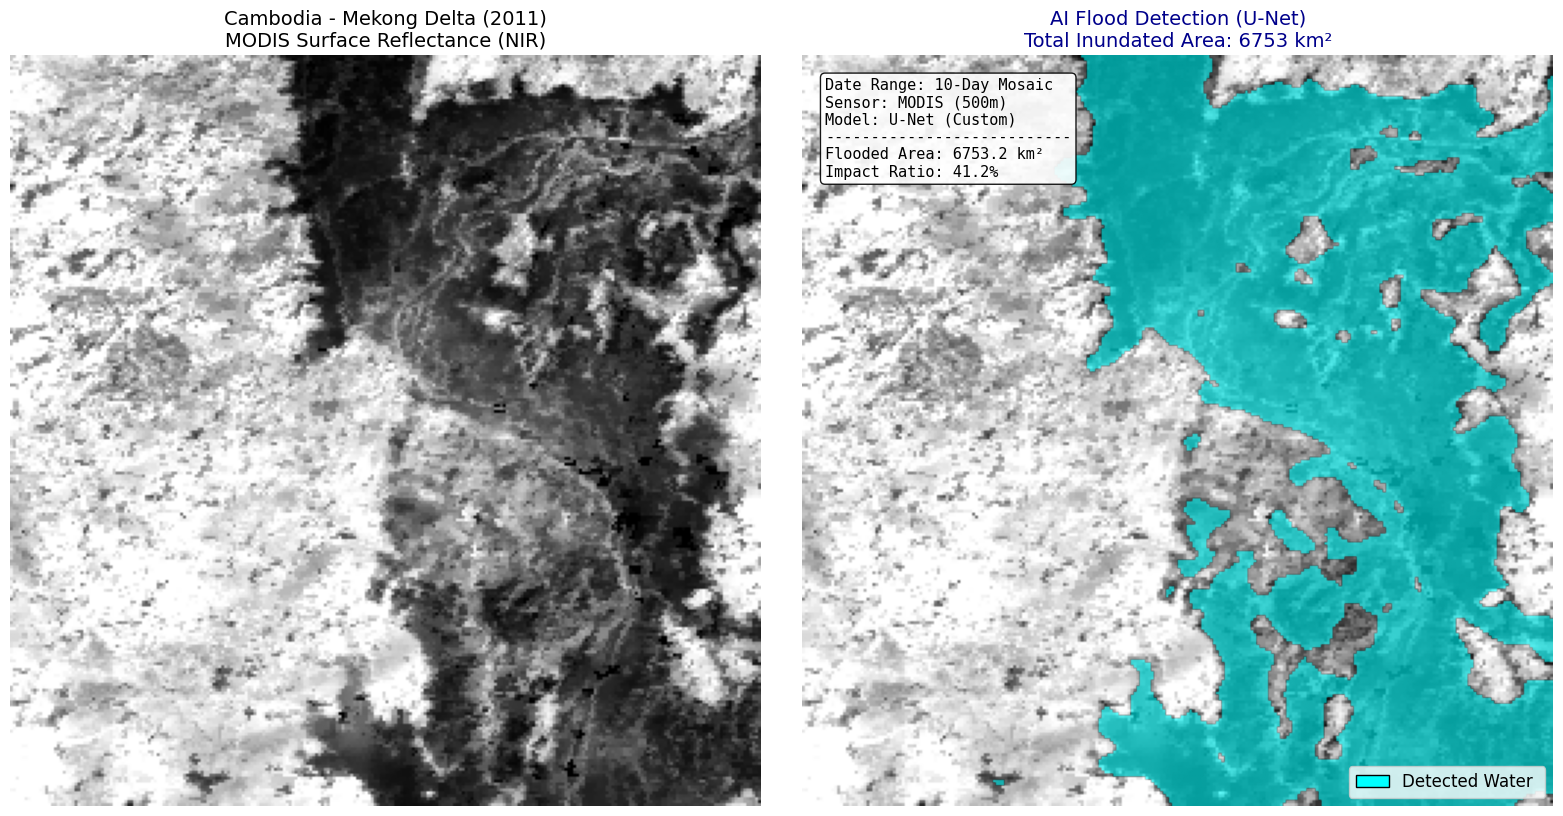


🌐 Processing: Brazil - Amazon Floods (2021)...


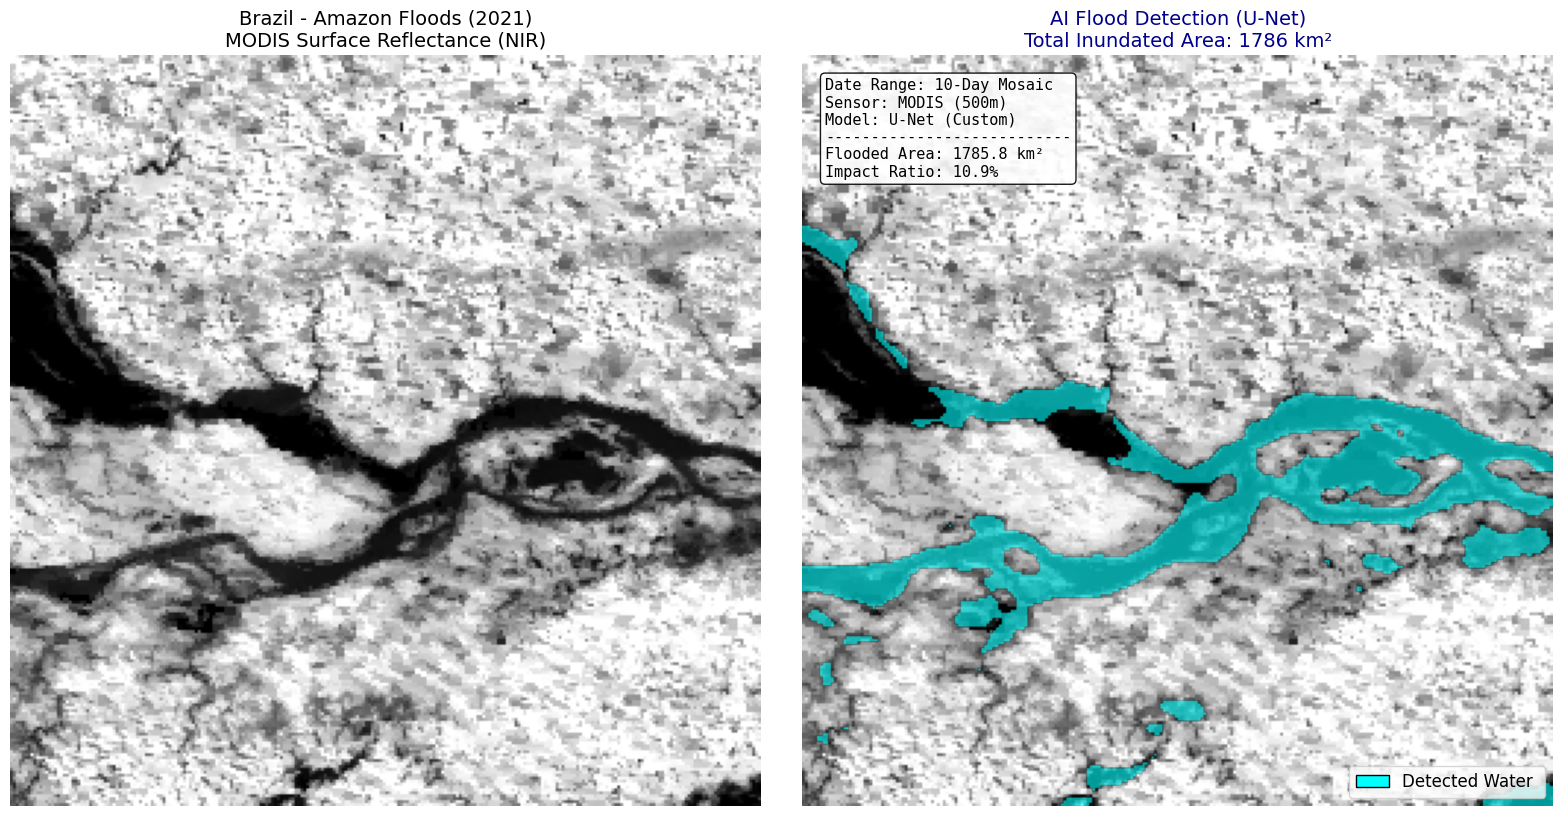


🌐 Processing: Canada - Spring Thaw (2019)...


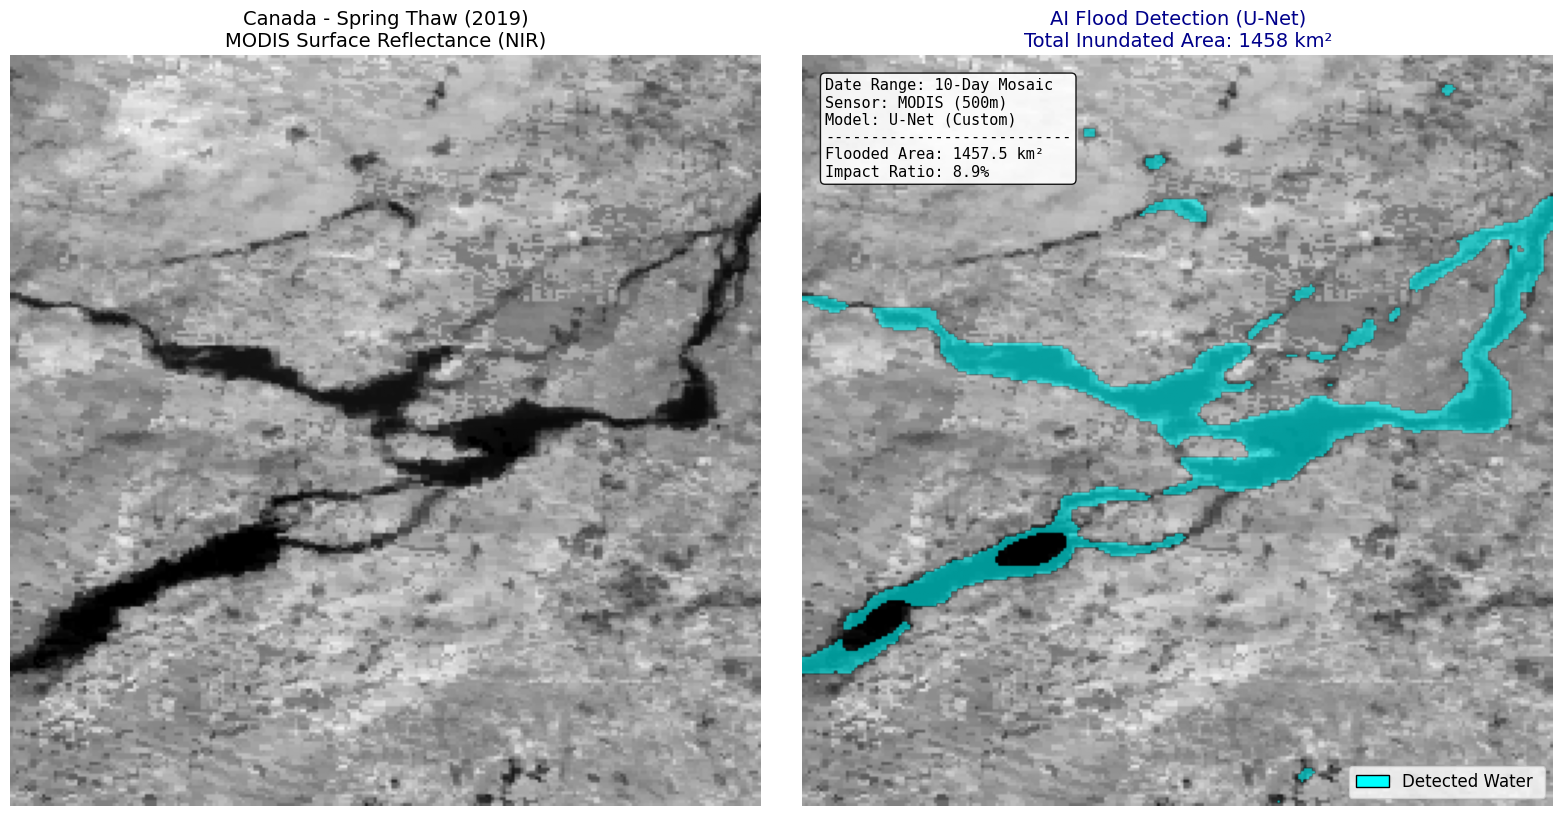

In [21]:
# @title 12. Execute Global Inference Loop (No Emojis)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import ee
from matplotlib.patches import Patch

# --- 1. Define Test Cases (Clean Names) ---
TEST_CASES = [
    {
        "name": "Mozambique - Cyclone Idai (2019)",
        "date_start": "2019-03-15", "date_end": "2019-03-25",
        "lat": -19.85, "lon": 34.50
    },
    {
        "name": "India - Bihar Floods (2017)",
        "date_start": "2017-08-10", "date_end": "2017-08-20",
        "lat": 26.10, "lon": 85.90
    },
    {
        "name": "Cambodia - Mekong Delta (2011)",
        "date_start": "2011-10-10", "date_end": "2011-10-20",
        "lat": 11.5, "lon": 104.9
    },
    {
        "name": "Brazil - Amazon Floods (2021)",
        "date_start": "2021-05-15", "date_end": "2021-05-25",
        "lat": -3.1, "lon": -60.0
    },
    {
        "name": "Canada - Spring Thaw (2019)",
        "date_start": "2019-04-20", "date_end": "2019-04-30",
        "lat": 45.4, "lon": -74.0
    }
]

# --- 2. Helper: Professional Plotting Function ---
def plot_flood_analysis(rgb_img, flood_mask, case_name, area_km2, flood_pct):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Subplot 1: Raw Satellite
    ax[0].imshow(rgb_img, cmap='gray', vmin=0, vmax=0.3)
    ax[0].set_title(f"{case_name}\nMODIS Surface Reflectance (NIR)", fontsize=14)
    ax[0].axis('off')

    # Subplot 2: Analysis Map
    ax[1].imshow(rgb_img, cmap='gray', vmin=0, vmax=0.3)

    # Cyan Overlay
    overlay = np.zeros((256, 256, 4))
    overlay[flood_mask == 1] = [0, 1, 1, 0.6]
    ax[1].imshow(overlay)

    ax[1].set_title(f"AI Flood Detection (U-Net)\nTotal Inundated Area: {area_km2:.0f} km²", fontsize=14, color='darkblue')
    ax[1].axis('off')

    # Legend
    legend_elements = [
        Patch(facecolor='cyan', edgecolor='black', label='Detected Water ')
    ]
    ax[1].legend(handles=legend_elements, loc='lower right', fontsize=12)

    # Info Box
    textstr = '\n'.join((
        f"Date Range: 10-Day Mosaic",
        f"Sensor: MODIS (500m)",
        f"Model: U-Net (Custom)",
        f"---------------------------",
        f"Flooded Area: {area_km2:.1f} km²",
        f"Impact Ratio: {flood_pct:.1f}%"
    ))

    props = dict(boxstyle='round', facecolor='white', alpha=0.9)
    ax[1].text(0.03, 0.97, textstr, transform=ax[1].transAxes, fontsize=11,
            verticalalignment='top', bbox=props, family='monospace')

    plt.tight_layout()
    plt.show()

# --- 3. The Analysis Logic ---
def analyze_flood_event(case):
    print(f"\n🌐 Processing: {case['name']}...")
    point = ee.Geometry.Point([case['lon'], case['lat']])
    region = point.buffer(70000).bounds()

    # Cloud-Free Mosaic
    mosaic = ee.ImageCollection('MODIS/061/MOD09GA') \
        .filterDate(case['date_start'], case['date_end']) \
        .filterBounds(point) \
        .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b06']) \
        .min() \
        .reproject(crs='EPSG:4326', scale=500)

    try:
        sample = mosaic.divide(10000).sampleRectangle(region=region, defaultValue=0)
        b1 = np.array(sample.get('sur_refl_b01').getInfo())
        b2 = np.array(sample.get('sur_refl_b02').getInfo())
        b6 = np.array(sample.get('sur_refl_b06').getInfo())

        rgb_stack = np.dstack((b1, b2, b6))
        input_tensor = tf.convert_to_tensor(rgb_stack, dtype=tf.float32)
        input_tensor = tf.image.resize_with_crop_or_pad(input_tensor, 256, 256)
        rgb_fixed = input_tensor.numpy()

        input_batch = tf.expand_dims(input_tensor, axis=0)
        pred_raw = model.predict(input_batch, verbose=0)

        # Threshold 0.2
        flood_map = pred_raw[0, :, :, 0] > 0.2

        flooded_km2 = np.sum(flood_map) * 0.25
        flood_pct = (np.sum(flood_map) / (256*256)) * 100

        plot_flood_analysis(rgb_fixed[:, :, 1], flood_map, case['name'], flooded_km2, flood_pct)

    except Exception as e:
        print(f"   ❌ Error: {e}")

# --- 4. Execute ---
for case in TEST_CASES:
    analyze_flood_event(case)